<a href="https://colab.research.google.com/github/georgemoum-cylearn/gmlearn/blob/main/Threat_Hunting.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#εισαγωγή βιβλιοθηκών - πακέτων
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [ ]:
#εισαγωγή του συνόλου δεδομένων
dataset = pd.read_csv("https://raw.githubusercontent.com/kdemertzis/EKPA/main/Data/Network-flows.csv", low_memory=False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
dataset.head()

,src_ip,src_port,dst_ip,dst_port,proto,pktTotalCount,octetTotalCount,min_ps,max_ps,avg_ps,std_dev_ps,flowStart,flowEnd,min_piat,max_piat,avg_piat,std_dev_piat,flowEndReason,flowDuration
0,192.168.128.196,56628,172.217.30.202,443,17,13,4593,48,1378,353.307692,477.499639,1.559669e+09,1.559669e+09,0.000002,0.084657,0.016367,0.024788,2,0.196405
1,192.168.128.196,57827,172.16.255.200,53,17,2,178,63,115,89.000000,26.000000,1.559669e+09,1.559669e+09,0.000451,0.000451,0.000451,0.000000,2,0.000451
2,192.168.128.196,57828,172.217.30.195,443,17,7,3050,48,1378,435.714286,595.980037,1.559669e+09,1.559669e+09,0.000004,0.037101,0.018151,0.017887,2,0.108904
3,192.168.128.196,53059,172.16.255.200,53,17,2,170,65,105,85.000000,20.000000,1.559669e+09,1.559669e+09,0.000229,0.000229,0.000229,0.000000,2,0.000229
4,192.168.128.196,57299,172.16.255.200,53,17,2,200,70,130,100.000000,30.000000,1.559669e+09,1.559669e+09,0.000589,0.000589,0.000589,0.000000,2,0.000589


In [ ]:
# έλεγχος συνόλου δεδομένων
dataset.shape


(155123, 19)

In [ ]:
#έλεγχος κενών τιμών στα δεδομένα
dataset.isnull().sum()

,0
src_ip,0
src_port,0
dst_ip,0
dst_port,0
proto,0
pktTotalCount,0
octetTotalCount,0
min_ps,0
max_ps,0
avg_ps,0


In [ ]:
# απαλοιφή μη αποδεκτών τιμών
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
dataset.dropna(inplace=True)

In [ ]:
# εμφάνιση τύπων δεδομένων συνόλου δεδομένων
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155123 entries, 0 to 155122
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   src_ip           155123 non-null  object 
 1   src_port         155123 non-null  int64  
 2   dst_ip           155123 non-null  object 
 3   dst_port         155123 non-null  int64  
 4   proto            155123 non-null  int64  
 5   pktTotalCount    155123 non-null  int64  
 6   octetTotalCount  155123 non-null  int64  
 7   min_ps           155123 non-null  int64  
 8   max_ps           155123 non-null  int64  
 9   avg_ps           155123 non-null  float64
 10  std_dev_ps       155123 non-null  float64
 11  flowStart        155123 non-null  float64
 12  flowEnd          155123 non-null  float64
 13  min_piat         155123 non-null  float64
 14  max_piat         155123 non-null  float64
 15  avg_piat         155123 non-null  float64
 16  std_dev_piat     155123 non-null  floa

In [ ]:
# Calculate 'Flow_Bytes/s' from existing columns, handling division by zero
dataset['Flow_Bytes/s'] = np.where(
    dataset['flowDuration'] != 0,
    dataset['octetTotalCount'] / dataset['flowDuration'],
    np.nan # Assign NaN where flowDuration is zero
)

# Remove any rows with NaN values introduced by the calculation to maintain data integrity
dataset.dropna(inplace=True)

In [ ]:
# ομαδοποίηση των κατηγοριών δικτύων της προτελευταίας στήλης 'Label-1'
dataset.groupby(dataset['Label-1']).size()

,0
Label-1,
1,75696
3,68813


In [ ]:
# Initialize 'Label-1' column with a default value (e.g., 'Non-Tor')
dataset['Label-1'] = 'Non-Tor'

# Define your conditions and corresponding choices
# IMPORTANT: Replace these example conditions with your actual rules
conditions = [
    # Tor conditions: Common Tor ports (9001, 9030, 9050) or common web ports used by Tor (80, 443)
    # OR if the destination IP is in the fetched Tor exit node list
    ((dataset['dst_port'] == 9001) & (dataset['proto'] == 6)) | \
    ((dataset['dst_port'] == 9030) & (dataset['proto'] == 6)) | \
    ((dataset['dst_port'] == 9050) & (dataset['proto'] == 6)) | \
    (dataset['dst_ip'].isin(tor_exit_ips)), # Add condition for Tor exit IPs

    # VPN conditions: Common ports for OpenVPN (UDP), PPTP (TCP), IKE (UDP)
    ((dataset['dst_port'] == 1194) & (dataset['proto'] == 17)) | \
    ((dataset['dst_port'] == 1723) & (dataset['proto'] == 6)) | \
    ((dataset['dst_port'] == 500) & (dataset['proto'] == 17)), # OpenVPN UDP, PPTP TCP, IKE UDP

    # NonVPN condition: Common HTTP/HTTPS traffic (prioritized after Tor/VPN checks)
    (dataset['dst_port'] == 80) | (dataset['dst_port'] == 443)
]

choices = [
    'Tor', # Label if the first condition (Tor) is True
    'VPN', # Label if the second condition (VPN) is True
    'NonVPN' # Label if the third condition (common web) is True
]

# Apply the conditions to create the 'Label-1' column
# Flows that don't match any condition will retain the default value ('Non-Tor')
dataset['Label-1'] = np.select(conditions, choices, default=dataset['Label-1'])

# Let's count the new labels to see the distribution
print("Distribution of 'Label-1' before numeric mapping:")
display(dataset.groupby(dataset['Label-1']).size())

# Map the string labels to numerical values
network_categories = {'Tor': 0, 'Non-Tor': 1, 'VPN': 2, 'NonVPN': 3}
dataset['Label-1'] = dataset['Label-1'].map(network_categories)

print("\nDistribution of 'Label-1' after numeric mapping:")
display(dataset.groupby(dataset['Label-1']).size())

Distribution of 'Label-1' before numeric mapping:


,0
Label-1,
Non-Tor,75693
NonVPN,68813
VPN,3



Distribution of 'Label-1' after numeric mapping:


,0
Label-1,
1,75693
2,3
3,68813


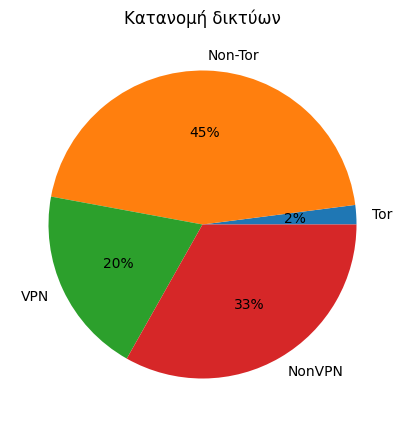

In [ ]:
# γραφική απεικόνιση δεδομένων με βάση το εάν είναι Tor - Non-Tor - VPN - NonVPN
type_classify=['Tor', 'Non-Tor', 'VPN', 'NonVPN']
count_classify=[1392, 30884, 13517, 22738]
fig, ax = plt.subplots(figsize=(7, 5))
ax.pie(count_classify, labels=type_classify, autopct='%0.f%%')
ax.set_title('Κατανομή δικτύων')
plt.show()

In [ ]:
# επιλογή ανεξάρτητων μεταβλητών
# Correcting the features list to include only existing columns in the dataset
existing_columns = dataset.columns.tolist()

features = [
    'proto', 'flowDuration', 'pktTotalCount', 'octetTotalCount',
    'min_ps', 'max_ps', 'avg_ps', 'std_dev_ps', 'Flow_Bytes/s',
    'min_piat', 'max_piat', 'avg_piat', 'std_dev_piat'
]

# Filter the features list to ensure only existing columns are included
features = [f for f in features if f in existing_columns]

print(f"Selected features: {features}")


Selected features: ['proto', 'flowDuration', 'pktTotalCount', 'octetTotalCount', 'min_ps', 'max_ps', 'avg_ps', 'std_dev_ps', 'Flow_Bytes/s', 'min_piat', 'max_piat', 'avg_piat', 'std_dev_piat']


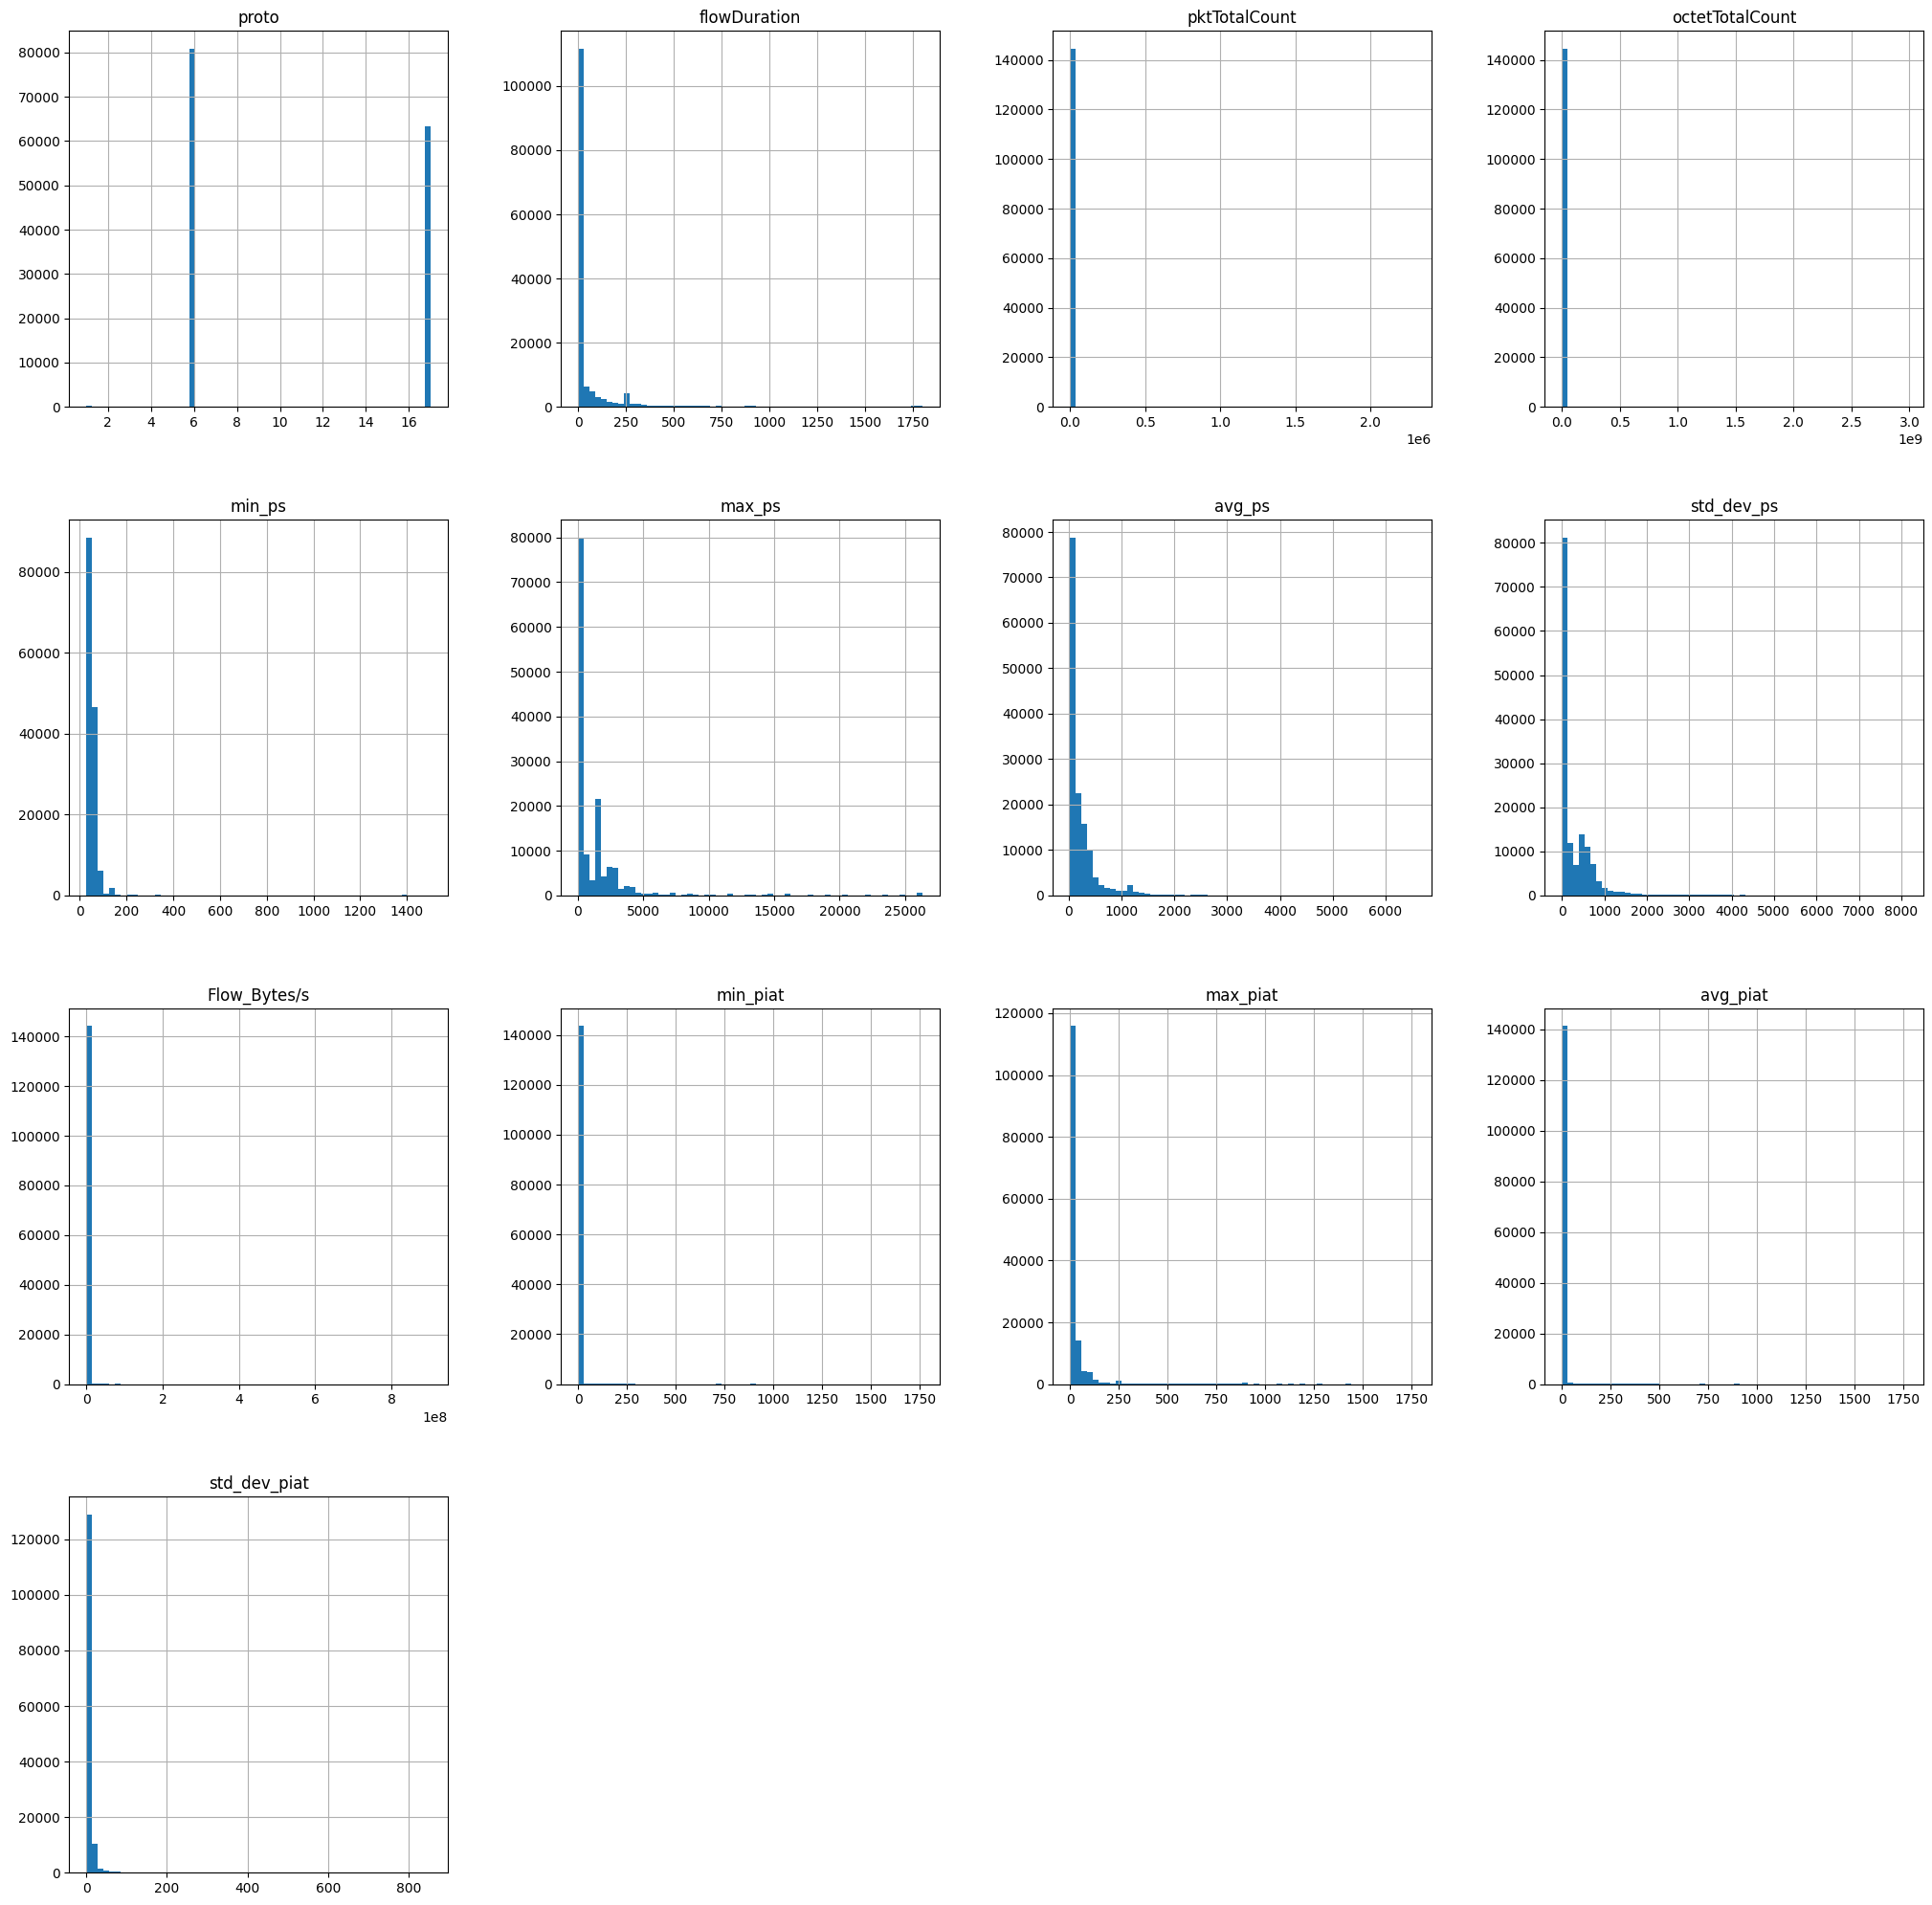

In [ ]:
# οπτικοποίηση της κατανομής των δεδομένων
dataset[features].hist(bins = 60,figsize = (25,25))
plt.show()

To get a list of Tor exit nodes, we can try to fetch it from the Tor Project's official bulk exit list. Please note that these lists are dynamic and can change frequently. This method relies on an external service being available.

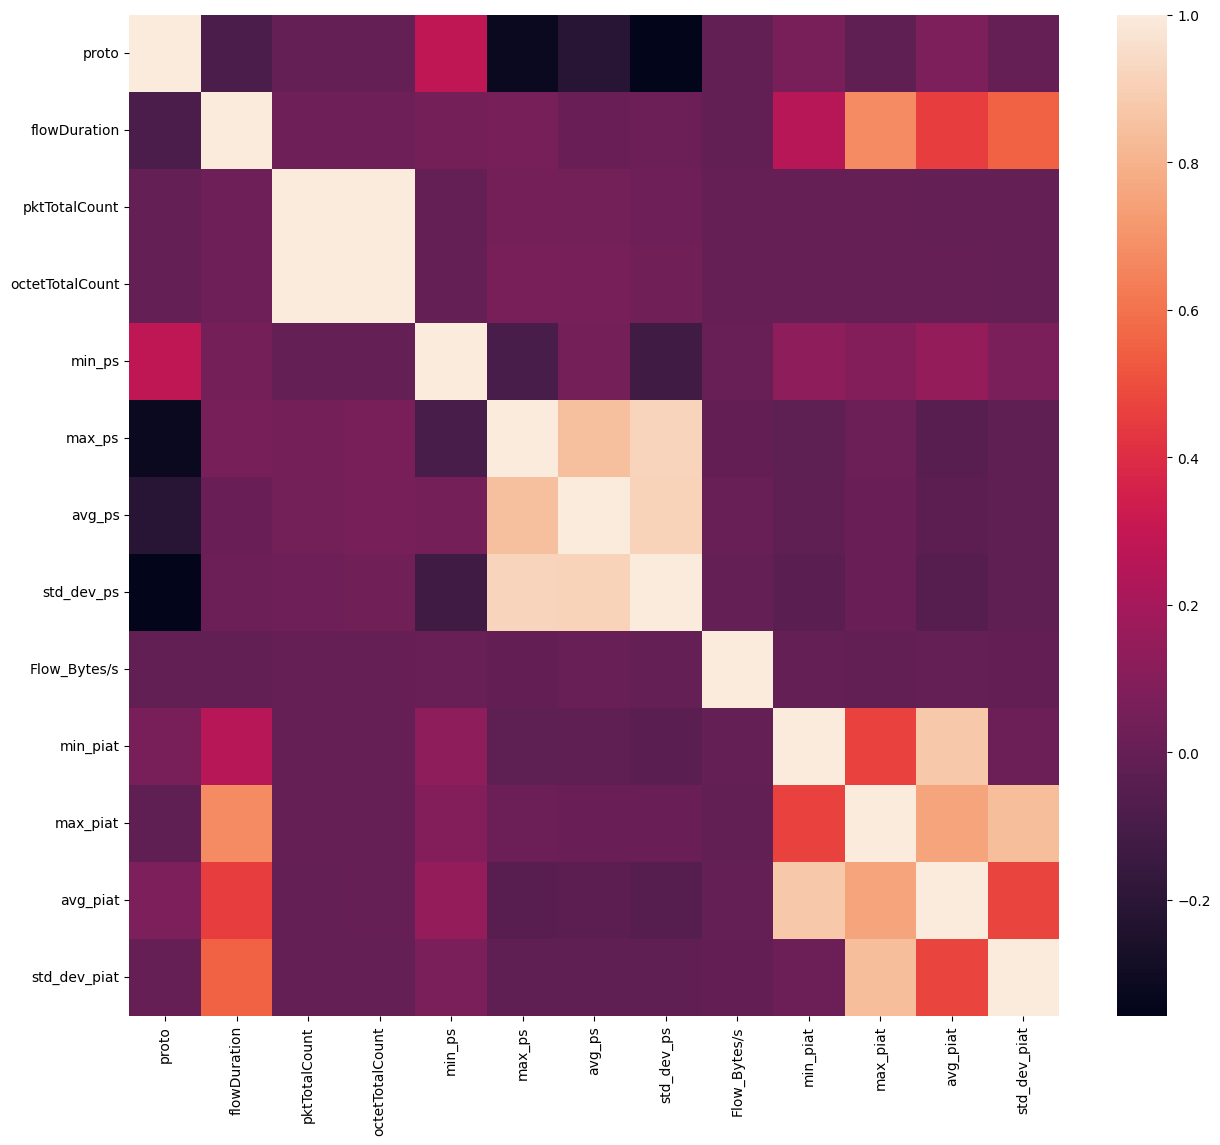

In [ ]:
# πίνακας συσχέτισης χαρακτηριστικών του συνόλου δεδομένων
plt.figure(figsize=(15,13))
sns.heatmap(dataset[features].corr())
plt.show()

In [ ]:
# αντιστίχοιση κατηγοριών δικτυακής κίνησης με αριθμητικές τιμές
network_categories = {'Tor': 0, 'Non-Tor': 1, 'VPN': 2, 'NonVPN': 3}
dataset['Label-1'] = dataset['Label-1'].map(network_categories)


In [ ]:
# διαχωρισμός και εκχώρηση ανεξάρτητων μεταβλητών σε X και μεταβλητών στόχων σε y
# one hot κωδικοποίηση των εφαρμογών της τελευταίας στήλης 'Label-2' (this comment is now outdated as 'Label-2' is removed)

# Drop rows where 'Label-1' is NaN to ensure target variable is clean
dataset_cleaned = dataset.dropna(subset=['Label-1'])

X = dataset_cleaned[features]
y = dataset_cleaned['Label-1']

X.shape, y.shape

((144509, 13), (144509,))

In [ ]:
# δημιουργία αντικειμένου ταξινομητή (μοντέλου) τύπου Decision Tree
tree = DecisionTreeClassifier(max_depth = 14)


In [ ]:
# εκπαίδευση του μοντέλου Decision Tree με το 80% του συνόλου των δεδομένων εκπαίδευσης (X_train)
tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=14)

In [ ]:
# Διαχωρισμός των δεδομένων σε σύνολα εκπαίδευσης και δοκιμής (80% εκπαίδευση, 20% δοκιμή)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (115607, 13)
y_train shape: (115607,)
X_test shape: (28902, 13)
y_test shape: (28902,)


In [ ]:
# πρόβλεψη της απόκρισης του μοντέλου με το υπόλοιπο 20% του συνόλου των δεδομένων δοκιμών (X_test)
y_pred_test = tree.predict(X_test)


In [ ]:
# η αρκίβεια του μοντέλου μετά την εκπαίδευση
decision_tree_accuracy = accuracy_score(y_test, y_pred_test)
print("Decision Tree Accuracy:", decision_tree_accuracy)


Decision Tree Accuracy: 0.9606255622448273


In [ ]:
# δημιουργία αντικειμένου ταξινομητή (μοντέλου) τύπου Random Forest
forest = RandomForestClassifier(max_depth=14)


In [ ]:
# εκπαίδευση του μοντέλου Random Forest με το 80% του συνόλου των δεδομένων εκπαίδευσης (X_train)
forest.fit(X_train,y_train)

RandomForestClassifier(max_depth=14)

In [ ]:
# πρόβλεψη της απόκρισης του μοντέλου με το υπόλοιπο 20% του συνόλου των δεδομένων δοκιμών (X_test)
y_pred_test = forest.predict(X_test)

In [ ]:
# η αρκίβεια του μοντέλου μετά την εκπαίδευση
random_forest_accuracy = accuracy_score(y_test, y_pred_test)
print("Random Forest Accuracy:", random_forest_accuracy)


Random Forest Accuracy: 0.9655733167254861


In [ ]:
# σύγκριση ακρίβειας μοντέλων
results = pd.DataFrame({ 'ML Model': ['Decicion Tree', 'Random Forest'],
    'Test Accuracy': [decision_tree_accuracy, random_forest_accuracy]})
results

,ML Model,Test Accuracy
0,Decicion Tree,0.960626
1,Random Forest,0.965573
